# Automated Assistant for Course Management

Welcome to the automated assistant for course management! This program will allow you to automate the process of scheduling semester courses at 15 courses/sec. You don't have to know programming to run this program. You simply need to hover over the each cell and click on the arrow icon to run them. Follow through to see how you can schedule your course!

In [ ]:
#@title Install the files for this program
!git clone https://github.com/mellieho9/technica-2022

Cloning into 'technica-2022'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 141 (delta 25), reused 1 (delta 1), pack-reused 85
Receiving objects: 100% (141/141), 64.46 KiB | 1.57 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
#@title Install the necessary library
!pip install z3-solver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 12.6 MB/s eta 0:00:00


In [ ]:
#@title Run this file to create the scheduling function
# Mel, Suruchi, Erin, Akshitha, Maria
# Making code account for different durations and days

from z3 import *
import pandas as pd

'''
Number of time slots in the day for MWF: 
0 => 08:00-08:50
1 => 09:00-09:50
2 => 10:00-10:50
3 => 11:00-11:50
4 => 12:00-12:50
5 => 13:00-13:50
6 => 14:00-14:50
7 => 15:00-15:50
8 => 16:00-16:50
Number of time slots in the day for TTh: 
0 => 08:00-9:15
1 => 09:30-10:45
2 => 11:00-12:15
3 => 12:30-13:45
4 => 14:00-15:15
5 => 15:30-16:45
'''
TIME_SLOTS_A = 9
TIME_SLOTS_B = 6

DAYS = 2

'''
Class object. Stores class name, size, professor, and identifier to group lectures/discussions
e.g., Class("A", 30)
'''
class Class:
    def __init__(self, name, size, professor, identifier):
        self.name = name
        self.size = size
        self.number = identifier
        self.professor = professor
'''
Room object. Stores room name and size.
e.g., Room("X", 45)
'''
class Room:
    def __init__(self, name, size):
        self.name = name
        self.size = size

'''
Input: List of Classes
Input: List of Rooms
Output: Prints Schedule
'''
def schedule(classes, rooms):

    s = Solver()

    # Put input data in a more convenient format
    class_names = [ c.name for c in classes ]
    class_sizes = [ c.size for c in classes ]
    class_professor = [c.professor for c in classes ]
    room_names = [ r.name for r in rooms ]

    # Create five variables for every class.
    # The first variable describes the (index of the) assigned room, the second
    # describes the time slot, and the third describes the size of the assigned room.
    vars = []
    for c in classes:
        c_vars = [Int("%s_room" % c.name), Int("%s_time" % c.name), Int("%s_size" % c.name), Int("%s_days" % c.name), Int("%s_professor" % c.name)] 
        vars.append(c_vars)

    # Every class must be assigned a valid room
    for i in range(len(classes)):
        room = vars[i][0]
        s.add(And(0 <= room, room < len(rooms)))

    # Every class must be assigned a valid time slot
    for i in range(len(classes)):
        time = vars[i][1]
        days = vars[i][3]
        s.add(Implies(days == 0, And(0 <= time, time < TIME_SLOTS_A)))
        s.add(Implies(days == 1, And(0 <= time, time < TIME_SLOTS_B)))

    # Every class must be assigned a pattern of days
    for i in range(len(classes)):
        days = vars[i][3]
        s.add(And(0 <= days, days < DAYS))

    # The assigned room determines the assigned room size
    for i in range(len(classes)):
        for j in range(len(rooms)):
            room = vars[i][0]
            size = vars[i][2]
            s.add(Implies(room == j, size == rooms[j].size))

    # No two classes can be assigned to the same room during the same time slot
    for i in range(len(classes)):
        for j in range(i+1, len(classes)):
            room_i = vars[i][0]
            room_j = vars[j][0]
            time_i = vars[i][1]
            time_j = vars[j][1]
            days_i = vars[i][3]
            days_j = vars[j][3]
            s.add(Not(And(room_i == room_j, time_i == time_j, days_i == days_j)))

            if classes[i].number == classes[j].number:
                s.add(Not(And(time_i == time_j, days_i == days_j)))

    #AKSHITHA: No two classes can have the same professor during the same time slot
    for i in range(len(classes)):
        for j in range(i+1, len(classes)):
            professor_i = vars[i][4]
            professor_j = vars[j][4]
            time_i = vars[i][1]
            time_j = vars[j][1]
            days_i = vars[i][3]
            days_j = vars[j][3]
            s.add(Not(And(professor_i == professor_j, time_i == time_j, days_i == days_j)))
    
    # The size of the class must be at most the capacity of the room
    for i in range(len(classes)):
        size = vars[i][2]
        s.add(class_sizes[i] <= size)

    valid = True

    # Check if a solution exists
    if s.check() == unsat:
        valid = False;
        print("No valid schedule")

    # MEL: Export the solution into a calendar.csv file which can be visualized on Google Calendar
    if valid == True:
        m = s.model()
        data = []
        for i in range(len(classes)):
            room = m[vars[i][0]].as_long()
            time = m[vars[i][1]].as_long()
            days = m[vars[i][3]].as_long()
            start_time = ""
            end_time = ""
            start_date = ""
            if days == 0:
              start_time, end_time = print_timeA(time)
              data.append([class_names[i],"10/17/2022",start_time,end_time,False,"With %s" % class_professor[i],room_names[room]])
              data.append([class_names[i],"10/19/2022",start_time,end_time,False,"With %s" % class_professor[i],room_names[room]])
              data.append([class_names[i],"10/21/2022",start_time,end_time,False,"With %s" % class_professor[i],room_names[room]])
            elif days == 1: 
              start_time, end_time = print_timeB(time)
              data.append([class_names[i],"10/18/2022",start_time,end_time,False,"With %s" % class_professor[i],room_names[room]])
              data.append([class_names[i],"10/20/2022",start_time,end_time,False,"With %s" % class_professor[i],room_names[room]])
            
        df = pd.DataFrame(data, columns=['Subject', 'Start Date','Start Time','End Time','All Day Event','Description','Location'])
        print(df)
        df.to_csv('calendar.csv')


def print_timeA(t):
    start = ""
    end = ""
    if t == 0:
        start = "08:00 AM"
        end = "08:50 AM"
    elif t == 1:
        start = "09:00 AM"
        end = "09:50 AM"
    elif t == 2:
        start = "10:00 AM"
        end = "10:50 AM"
    elif t == 3:
        start = "11:00 AM"
        end = "11:50 AM"
    elif t == 4:
        start = "12:00 PM"
        end = "12:50 PM"
    elif t == 5:
        start = "1:00 PM"
        end = "1:50 PM"
    elif t == 6:
        start = "2:00 PM"
        end = "2:50 PM"
    elif t == 7:
        start = "3:00 PM"
        end = "3:50 PM"
    elif t == 8:
        start = "4:00 PM"
        end = "4:50 PM"
    else:
        raise(Exception("Invalid time slot: %d" % t))
    return start, end

def print_timeB(t):
    start = ""
    end = ""
    if t == 0:
      start = "08:00 AM"
      end = "09:15 AM"
    elif t == 1:
      start = "09:30 AM"
      end = "10:45 AM"
    elif t == 2:
      start = "11:00 AM"
      end = "12:15 PM"
    elif t == 3:
      start = "12:30 PM"
      end = "1:15 PM"
    elif t == 4:
      start = "2:00 PM"
      end = "3:15 PM"
    elif t == 5:
      start = "3:30 PM"
      end = "4:45 PM"
    else:
      raise(Exception("Invalid time slot: %d" % t))
    return start, end



### Now you simply need to import a text file or let us run our built-in file to automate course scheduling. 

If you intend to import a text file, please implement them to be as the following format.

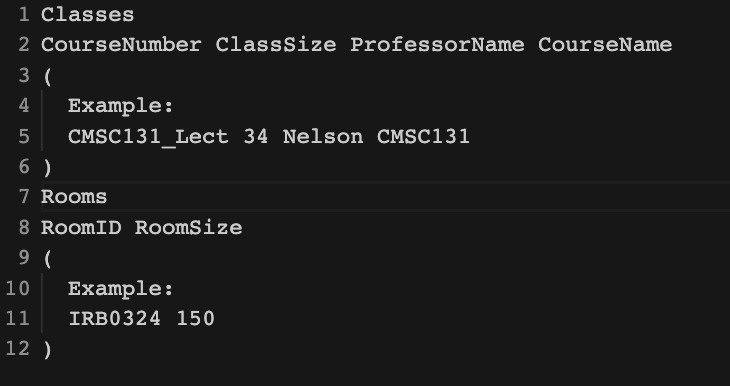

To import a text file, click on the file icon on the left. This would open a pane titled "Files". Under the title "Files", click on the leftmost icon, this icon will allow you to import files from your desktop.

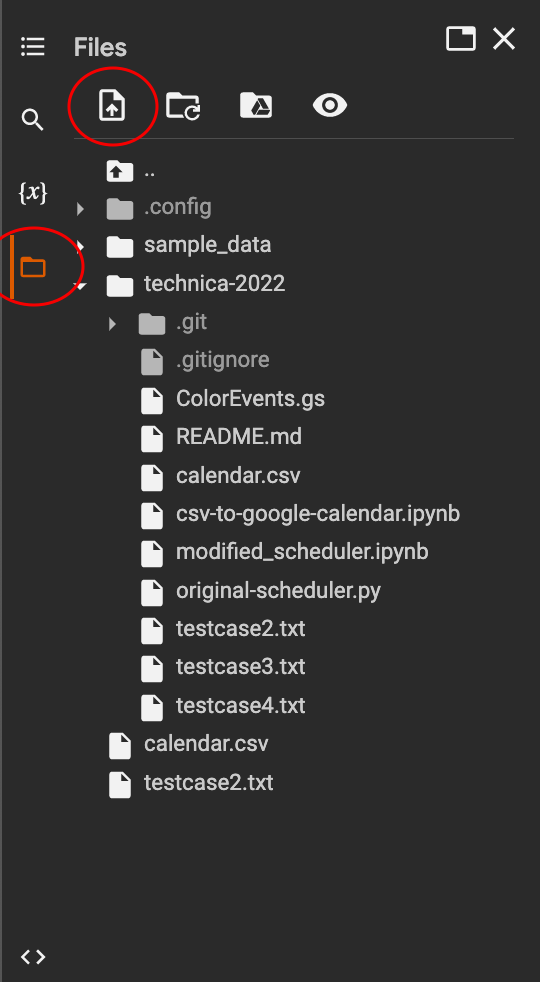

In [ ]:
#@title Import the text file and enter the name of your file (in the format file_name.txt). Then, click on the arrow icon to run the program. You will be able to find a "calendar.csv" file in the "Files" panel, which contains the schedule for all courses.
# ERIN: Run a small instance of the scheduling problem AND create an input variable to allow cleaner data input

infilename = "technica-2022/testcase2.txt" #@param {type:"string"}


infile = open(infilename,'r')

nums = []

classesDone = False

classes = []
rooms = []
infile.readline()
while True:
    line = infile.readline()
    if not line:
        break
    if line[:7].lower() == "classes" or line == "\n":
        pass
    elif line[:5].lower() == "rooms":
        classesDone = True
    elif not classesDone:
		    #append a new class instance to the classes list
        split1 = line.find(" ")
        split2 = line[split1+1:].find(" ") + split1 + 1
        split3 = line[split2+1:].find(" ") + split2 + 1
        classes.append(Class(line[:split1], int(line[split1:split2]), line[split2+1:split3], line[split3+1:len(line)-1]))
    else:
        #append a new room to the rooms instance
        split = line.find(" ")
        rooms.append(Room(line[:split], int(line[split:len(line)-1])))

infile.close()
schedule(classes, rooms)

          Subject Start Date Start Time  End Time  All Day Event  \
0    CMSC131_Lect     Monday    3:00 PM   3:50 PM          False   
1    CMSC131_Lect  Wednesday    3:00 PM   3:50 PM          False   
2    CMSC131_Lect     Friday    3:00 PM   3:50 PM          False   
3    CMSC131_Disc    Tuesday   08:00 AM  09:15 AM          False   
4    CMSC131_Disc   Thursday   08:00 AM  09:15 AM          False   
5    CMSC132_Lect     Monday    4:00 PM   4:50 PM          False   
6    CMSC132_Lect  Wednesday    4:00 PM   4:50 PM          False   
7    CMSC132_Lect     Friday    4:00 PM   4:50 PM          False   
8    CMSC132_Disc    Tuesday   08:00 AM  09:15 AM          False   
9    CMSC132_Disc   Thursday   08:00 AM  09:15 AM          False   
10   CMSC216_Lect    Tuesday   11:00 AM  12:15 PM          False   
11   CMSC216_Lect   Thursday   11:00 AM  12:15 PM          False   
12   CMSC216_Disc     Monday    3:00 PM   3:50 PM          False   
13   CMSC216_Disc  Wednesday    3:00 PM   3:50 P